# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>






## Carga de Datos y librerías

In [3]:
import pandas as pd
import numpy as np

import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('always')

In [4]:
dataset=pd.read_csv('./Datasets/properati_argentina_2021.csv')

## Análisis Exploratorio y Preprocesamiento de Datos

Exploración Inicial :

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [6]:
print(dataset.shape)
print(dataset.isna().sum())

(460154, 20)
id                               0
start_date                       0
end_date                         0
created_on                       0
latitud                      40414
longitud                     40414
place_l2                         0
place_l3                     22489
place_l4                    321134
place_l5                    457724
place_l6                    460154
operation                        0
property_type                    0
property_rooms               91656
property_bedrooms           116041
property_surface_total       62341
property_surface_covered     32238
property_price               18001
property_currency            18564
property_title                   0
dtype: int64


Eliminamos columnas no utiles

In [7]:
dataset.drop(['id' , 'place_l6'], axis='columns', inplace=True)


In [10]:
viviendas = dataset[dataset.property_type.isin(['Casa', 'PH', 'Departamento'])]  #deberiamos dejar la casa de campo?
viviendas_caba= viviendas[viviendas.place_l2 == 'Capital Federal']
viviendas_en_venta_caba = viviendas_caba[viviendas_caba.operation == 'Venta']
viviendas_en_venta_caba_usd = viviendas_en_venta_caba[viviendas_en_venta_caba.property_currency == 'USD']



viviendas_en_venta_caba_usd.drop(['start_date' , 'end_date', 'created_on', 'place_l2', 'operation', 'property_currency', 'place_l5'], axis='columns', inplace=True) #SACAMOS TODO A LA MIERDA incluyendo place_l5 por no tenber datos
viviendas_en_venta_caba_usd.head()

/var/folders/16/9ryflw7d7d762hwbly8zx04c0000gn/T/ipykernel_19806/2200308352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_en_venta_caba_usd.drop(['start_date' , 'end_date', 'created_on', 'place_l2', 'operation', 'property_currency', 'place_l5'], axis='columns', inplace=True) #SACAMOS TODO A LA MIERDA incluyendo place_l5 por no tenber datos


,latitud,longitud,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
25,NaN,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,-34.637319,-58.361124,Boca,NaN,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,-34.628647,-58.361871,Boca,NaN,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur
49,-34.610027,-58.401934,Once,NaN,Departamento,4.0,2.0,NaN,104.0,146000.0,Venta departamento 4 ambientes Once
51,-34.631621,-58.416825,Boedo,NaN,PH,4.0,2.0,NaN,73.0,250000.0,PH - Boedo


Seleccionamos solo las viviendas (Casa, PH y departamento) que se encuentren en venta en dolares en Capital Federal

volvemos a analizar datos faltantes sobre el nuevo dataset

In [11]:
viviendas_en_venta_caba_usd.isna().sum()


latitud                      3730
longitud                     3730
place_l3                      417
place_l4                    90606
property_type                   0
property_rooms               1044
property_bedrooms           10987
property_surface_total       4844
property_surface_covered     3354
property_price                  0
property_title                  0
dtype: int64

In [18]:

medidas_de_resumen = viviendas_en_venta_caba_usd.describe()
medidas_de_resumen.drop(['count' , 'std', 'min', 'max'], axis=0, inplace=True)
moda = viviendas_en_venta_caba_usd.mode()
moda.index = ['mode']

#aca moda tiene place_l3, property type y title (?) las saco provisionalmente. 
moda.drop(['place_l3', 'place_l4','property_type','property_title'], axis = 1, inplace = True) #Verificar valores !!!

medidas_de_resumen = pd.concat([medidas_de_resumen, moda])
medidas_de_resumen

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
mean,-34.591481,-58.449795,2.822799,2.014629,109.09297,87.931932,226238.207185
25%,-34.615975,-58.466522,2.000000,1.000000,45.00000,40.000000,95000.000000
50%,-34.595790,-58.439000,3.000000,2.000000,65.00000,58.000000,143900.000000
75%,-34.577413,-58.408862,4.000000,3.000000,105.00000,88.000000,237000.000000
mode,-34.541250,-58.472966,3.000000,1.000000,50.00000,40.000000,110000.000000


In [19]:
viviendas_en_venta_caba_usd.place_l3.value_counts()

Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          639
Villa Luga

In [20]:
viviendas_en_venta_caba_usd.head() #25	NaN	NaN	NaN	NaN	NaN	Casa	4.0	3.0	171.0	133.0	210000.0	VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
                                    #¿¿¿¿¿¿ que hacemos cuando property_title no coincide con place_l2 ??????

                                    #la primera que aparece ni siquiera esta en capital, hay que sacarlo pero si hay mas asi como hacemos????
                                    #hanria que sacar los null de place_l1 al prncipio.

,latitud,longitud,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
25,NaN,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,-34.637319,-58.361124,Boca,NaN,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,-34.628647,-58.361871,Boca,NaN,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur
49,-34.610027,-58.401934,Once,NaN,Departamento,4.0,2.0,NaN,104.0,146000.0,Venta departamento 4 ambientes Once
51,-34.631621,-58.416825,Boedo,NaN,PH,4.0,2.0,NaN,73.0,250000.0,PH - Boedo


In [83]:

viviendas_en_venta_caba_usd.place_l4.value_counts()

Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: place_l4, dtype: int64

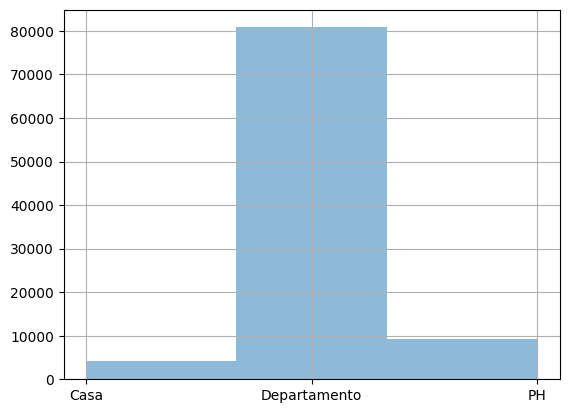

In [21]:
viviendas_en_venta_caba_usd.property_type.value_counts()
grf=viviendas_en_venta_caba_usd.property_type.hist(alpha=0.5,bins=3)
#PODEMOS HACER TORTA

In [22]:
viviendas_en_venta_caba_usd.property_title.value_counts()

Departamento - Palermo                                                                                  1468
Departamento - Recoleta                                                                                 1324
Departamento - Belgrano                                                                                 1113
Departamento - Caballito                                                                                 936
Departamento - Almagro                                                                                   666
                                                                                                        ... 
Gran 3 ambientes en pleno Villa del Parque                                                                 1
Venta PH 3 Amb Con Patio Flores                                                                            1
Venta, PH, 3 Ambientes, PB, Quincho, Parrilla, Terraza, Paternal                                           1
Venta PH - 3 dormit

/var/folders/16/9ryflw7d7d762hwbly8zx04c0000gn/T/ipykernel_19806/1724085558.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion=viviendas_en_venta_caba_usd.corr()


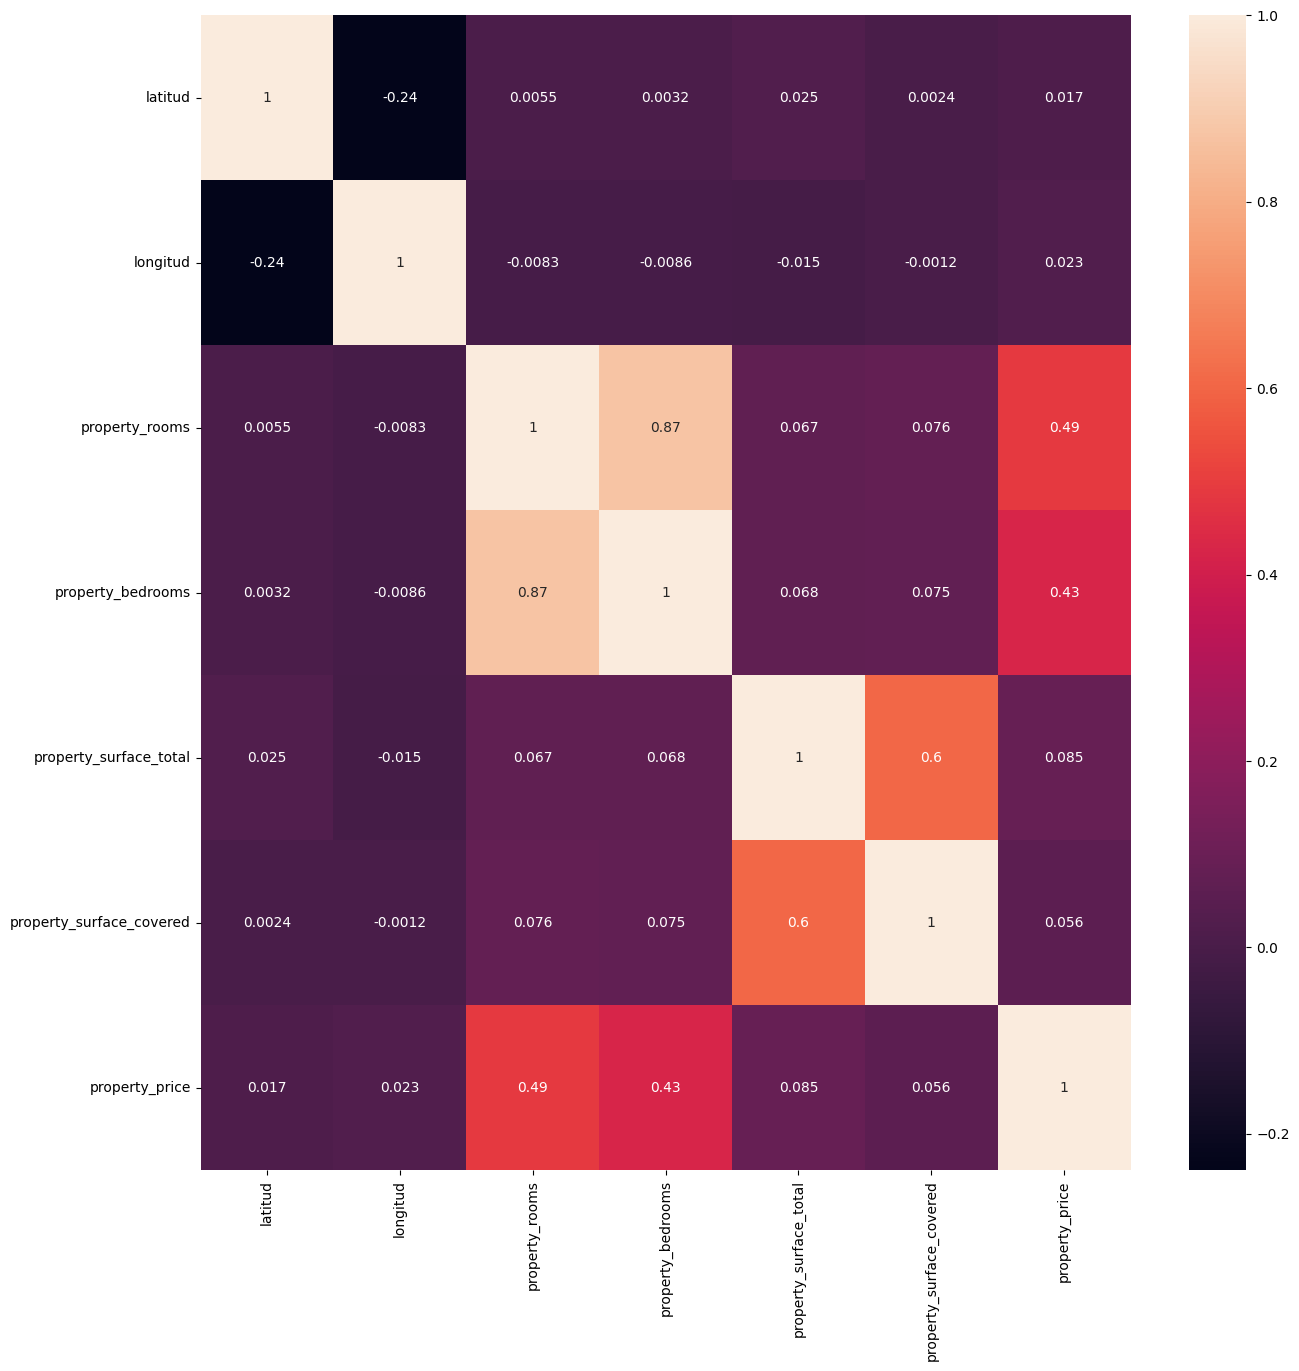

In [23]:
matriz_correlacion=viviendas_en_venta_caba_usd.corr()

plt.figure(figsize=(15,15))
sns.heatmap(matriz_correlacion, annot = True)
plt.show()